## Pose dataset and Data Preprocessing

references:
- [https://nanonets.com/blog/human-pose-estimation-2d-guide/](https://nanonets.com/blog/human-pose-estimation-2d-guide/)
- [https://towardsdatascience.com/human-pose-estimation-simplified-6cfd88542ab3](https://towardsdatascience.com/human-pose-estimation-simplified-6cfd88542ab3)

code references: 
- [https://github.com/bearpaw/pytorch-pose](https://github.com/bearpaw/pytorch-pose)
- [https://github.com/princeton-vl/pose-hg-train](https://github.com/princeton-vl/pose-hg-train)

### 2D Human Pose Estimation

#### What is Human Pose Estimation?

["Precise human pose estimation based on two-dimensional images for kinematic analysis"](https://www.spiedigitallibrary.org/conference-proceedings-of-spie/11330/113300F/Precise-human-pose-estimation-based-on-two-dimensional-images-for/10.1117/12.2542539.full?SSO=1) (2020)

> Human Pose Estimation (HPE) is a Computer Vision problem where the goal is to estimate keypoint locations in joints and body parts to describe the position and orientation of the bodies. This information allows us to recognize human actions and their interaction with a machine, opening a broad set of potential applications in the medical field such as therapy using virtual and augmented reality, robot caregivers, virtual physical therapy and kinematic analysis.

사람의 관절에 대해 파악하고 이해하는 것은 human computer interactions, gaming, virtual reality, video surveillance, sports analysis, medical assistance 등 많은 활용 가치가 있기에 과거부터 꾸준히 연구 되어온 분야입니다. 최근 Deep learning의 등장으로 다양한 분야의 연구들이 이전보다도 큰 성과를 보이고 있는데, human pose estimation 분야 또한, 2016년 Google이 제안한 Deep Pose 모델을 시작으로 활발히 연구가 이루어지고 있습니다.

<img src="https://miro.medium.com/max/2712/1*q8Bq1q0tb0BSCaVmcHygFw.png" width=400>

#### Training Pipeline

아래 그림은 ["Distribution Aware Coordinate Representation for Human Pose Estimation"](https://openaccess.thecvf.com/content_CVPR_2020/papers/Zhang_Distribution-Aware_Coordinate_Representation_for_Human_Pose_Estimation_CVPR_2020_paper.pdf)
논문에서 소개된 pose estimation 훈련 pipeline을 나타내고 있습니다. <br/>

<img src="./src_imgs/3.PNG" width=400> <br/>

- (a) Data Preprocessing : 모델을 훈련하기 전, 입력(input) 데이터와 목표(target) 데이터를 어떻게 구성할지 정하는 단계입니다. 예를 들어, 데이터셋의 source image는 resolution이 매우 클 수도, 매우 작을 수도 있습니다. 또한, 이미지들마다 서로 다른 resolution을 가지고 있을 수도 있습니다. 따라서 우선적으로 모델에 통일된 크기(prefixed size)의 이미지를 전달하기 위해 source image를 input image로 변환하는 과정이 필요합니다. 이 과정을 **Transform**이라고 하겠습니다. 또한, 데이터 셋에는 훈련을 위해 입력이미지와 한쌍인 label 즉, 포즈 좌표 annotation이 존재합니다. 입력 이미지의 resolution이 Transform에 의해 조정될 것이므로 그에 따라 포즈 좌표도 동일한 scale로 Transform 하는 과정이 필요합니다. 포즈 좌표는 vector로 표현되지만, 최근 많은 논문들은 이 vector를 heatmap으로 바꾸어 사용하고 있습니다. heatmap이란 1D인 vector와 다르게 2D로써 표현되며, 2D matrix의 각 요소들은 포즈가 존재할 probability를 계산하게 됩니다. 자세한 것은 이후에 설명하겠습니다.


- (b) Human Pose Estimation Model : 모델을 정의할 때 몇 가지 미리 정하여야하는 hyperparameters가 존재합니다. 예를 들어 데이터셋에 따라 pose 좌표들의 개수 곧, 사람 관절을 표현한 number of joints가 각기 다를 수 있습니다. 실제로 대표적인 데이터셋인 COCO Keypoint Detection, MPII, LSP는 서로 관절 개수가 다릅니다 (각각 17, 16, 14). 이를 고려한다면 모델 아키텍처 또한 달라질 수 있습니다. 결과적으로 이 과정에서 정의된 모델은 input image를 받아 predicted heatmaps에 관절 keypoints가 있을법한 위치를 regression 하게 됩니다. 본문에선 대표적인 CNN 모델 2가지를 소개하겠습니다. 


- (c) Model Training : 훈련과정 중 target heatmap(ground-truth heatmap)과 predicted heatmap간의 차이 곧, MSE(Mean Squared Error) loss를 계산합니다. 


- (d) Model Testing : 모델 성능을 테스트하기 위해선 정확한 지표가 필요합니다. Accuracy 측정에는 PCK, PCKh, OKS metric이 존재하는데, 그 중에 가장 간단한 측정 방법인 PCK(Percentage of Correct Keypoint)를 사용하겠습니다. PCK는 true keypoint 좌표와 predicted keypoint 좌표간의 거리가 일정 threshold안에 들어오는지 확인하여 정확도를 측정합니다. 

### Leeds Sports Pose Dataset

![](./src_imgs/4.PNG)

LSP dataset(1K training, 1K test images)와 LSP extended dataset(10K training images)은 Flickr로부터 특정 키워드로 수집된 스포츠 선수들의 이미지로 구성되어있습니다. **각 이미지는 사람이 약 150pixel 길이로 이미지의 중심에 위치하도록 조정되어 있습니다.** 

**LSP, LSP extended 데이터셋은 포즈 좌표를 joints.mat 파일에 저장하고 있습니다. 저희는 이 파일을 사용하지 않고 github에 공개된 파일(LEEDS_annotations.json)을 사용하겠습니다. 관절의 순서가 조금 다르고 LSP와 LSP extended의 annotation을 합친 것입니다.**

Joint index:

1. Right ankle
2. Right knee
3. Right hip
4. Left hip
5. Left knee
6. Left ankle
7. Neck
8. Head top
9. Right wrist
10. Right elbow
11. Right shoulder
12. Left shoulder
13. Left elbow
14. Left wrist

#### Download

Download link:
- LSP: [https://sam.johnson.io/research/lsp.html](https://sam.johnson.io/research/lsp.html)
- LSP extended: [https://sam.johnson.io/research/lspet.html](https://sam.johnson.io/research/lspet.html)
- LSP Annotation(edited by bearpaw): [https://drive.google.com/open?id=1GZxlTLuMfA3VRvz2jyv8fhJDqElNrgKS](https://drive.google.com/open?id=1GZxlTLuMfA3VRvz2jyv8fhJDqElNrgKS)

상단 링크를 따라 LSP(original scale 아님), LSP extended dataset 압축 파일과 LEEDS_annotations.json 파일을 다운받습니다. 
다운 받은 파일을 `./data/lsp`에 저장해주세요.

- `data/lsp/lsp_dataset`
- `data/lsp/lspet_dataset`
- `data/lsp/LEEDS_annotations.json`
          

#### Annotation
`LEEDS_annotations.json` 파일은 다음과 같은 정보를 dictionary 자료형에 기록하고 있습니다. 

EX)
- 'isValidation' (훈련 셋인지 테스트 셋인지 구분): 0.000 or 1.000 
- 'img_paths': "lspet_dataset\/images\/im00001.jpg"
- 'img_width': 157.000
- 'img_height': 105.000
- 'joint_self' ([x, y, vis_flag] 좌표 리스트): [[0.000,-26.109,0.000],[26.031,86.410,1.000],[50.608,75.701,1.000],[71.730,87.567,1.000],[49.170,89.006,1.000],[23.139,94.790,1.000],[61.169,81.634,1.000],[98.050,58.777,1.000],[96.885,56.611,1.000],[116.569,53.422,1.000],[131.312,13.805,1.000],[111.644,34.630,1.000],[93.711,49.091,1.000],[102.388,68.462,1.000],[110.784,88.427,1.000],[139.129,89.584,1.000]]
- 'objpos': [81.134,54.298] 대략적인 사람 중심 좌표
- 'scale_provided' (데이터셋에서 사람길이를 약 150px이 되도록 조정할때 사용한 scale): 0.581

#### Dataset class

이제 본격적으로 데이터셋을 다뤄보겠습니다. 앞으로는 여러가지 모듈들을 사용해야하므로 주제와 관련없는 코드의 경우 따로 설명하지는 않겠습니다. **소개하지 않는 모듈을 포함한 모든 코드는 `codes` 폴더에서 참고하시기 바랍니다.**

`lsp.py`에는 LSP dataset 클래스를 정의하고 있으며 다음과 같은 기능을 가지고 있습니다.

- 데이터셋으로부터 이미지 불러오기
- Annotation 파일로부터 관절 좌표 불러오기
- Transform (flip, scale, rotate, crop, color jittering, normalize)
- joint coordinate points를 heatmap으로 변환

Transform은 단순히 입력 이미지의 resolution을 조정하는 것 뿐만 아니라, **Data Augmentation**의 의미도 가지고 있습니다. LSP 데이터셋은 11K의 train images를 가지고 있으므로 다른 public dataset에 비해 훈련 데이터가 부족합니다. 이것은 모델의 overfitting을 야기할 수 있어서 모델 일반화 성능에 악영향을 끼칩니다. 이 때문에 최근 연구들은 적절한 Augmentation 방법으로 데이터 개수를 늘리고 있으며, 일반적으로 horizontal flip, scale(0.75 ~ 1.25), rotate(-30 ~ 30), color jittering을 사용하고 있습니다.

이제 `lsp.py` 데이터셋 클래스 코드에서 일부 가져와 Transform 과정을 확인해보겠습니다. 

In [1]:
import os
import random
import json

import torch
import torchvision.transforms as tvtf

from codes.utils.osutils import * # path 설정과 관련된 모듈
from codes.utils.imutils import * # 이미지 형식 변환(numpy format, torch format), heatmap 생성 모듈
from codes.utils.transforms import *  # transform 관련 모듈

inp_res = 256 # input 이미지 해상도 (prefixed size)
out_res = 64  # output 이미지 해상도 (heatmap)
sigma = 1 # gaussian distribution의 표준편차

jsonfile = join_path('data', 'lsp', 'LEEDS_annotations.json')

with open(jsonfile) as anno_file:
    anno = json.load(anno_file)

valid_list = []
train_list = []
for idx, obj in enumerate(anno):
    # pelvis(mid-hip), thorax(mid-shoulder)는 불필요하므로 주석에서 제거하였습니다.
    pts = obj['joint_self'] # Parts x 3 (x,y,vis_flag)
    del pts[6:8] # keypoint 16 -> 14

    # train set과 validation set의 이미지 리스트를 나눕니다.
    if obj['isValidation'] == True:
        valid_list.append(idx)
    else:
        train_list.append(idx)

# train set에서 미리 계산된 값들을 사용하였습니다. 
mean = [0.444205, 0.430209, 0.403942]
std = [0.237611, 0.229637, 0.235579]

sf = 0.25 # scale factor
rf = 30   # rotate factor
#transform = tvtf.Compose([ColorJittering(0.8, 1.2), ColorNormalize(mean, std)])
transform = tvtf.Compose([ColorJittering(0.8, 1.2)])

idx = 0 # train list의 첫번째 이미지를 사용하겠습니다.
obj = anno[train_list[idx]]

img_folder = join_path('data', 'lsp')
img_path = join_path(img_folder, get_correct_path(obj['img_paths']))
pts = torch.Tensor(obj['joint_self']) # keypoints 14

c = torch.Tensor(obj['objpos']) # rough human position in the image
s = obj['scale_provided']

# LSP uses matlab format, index is based 1,
# we should first convert to 0-based index
pts[:, 0:2] -= 1
c -= 1

# Adjust center/scale slightly to avoid cropping limbs
if c[0] != -1:
    #c[1] = c[1] + 15 * s
    s = s * 1.4375

nparts = pts.size(0)
origin_img = load_image(img_path) # CxHxW

# Transforms a image to feed the model's input
s = s * random.uniform(1 - sf, 1 + sf) # random scale (0.75 ~ 1.25)
r = random.uniform(-rf, rf) # random rotate (-30~30)

# flip
flip_img = fliplr_img(origin_img)
flip_pts = fliplr_joints(pts, width=flip_img.size(2), dataset='lsp')
c[0] = flip_img.size(2) - c[0]

# scaling, rotating and cropping
crop_img = crop(flip_img, c, s, [inp_res, inp_res], rot=r) # 256x256 resolution으로 변환
inp = transform(crop_img) # color jittering

# Generate ground truth
tpts = flip_pts.clone() # transformed points
target = torch.zeros(nparts, out_res, out_res)

for i in range(nparts):
    if tpts[i, 2] > 0: # vis_flag > 0, 보이지 않는 keypoint는 heatmap은 0 값으로 놔둔다.
        
        # origin image resolution 상의 좌표를 heatmap resolution 상의 좌표로 변환
        tpts[i, 0:2] = to_torch(affine_transform(tpts[i, 0:2], c, s, [out_res, out_res], rot=r))
        
        # 변환된 좌표를 이용해 gaussian distribution을 따르는 ground truth heatmap을 생성한다. 
        target[i], vis = draw_labelmap(target[i], tpts[i], sigma)


실제 변환된 이미지와 좌표를 시각화해봅니다. 

여기서 중요한 것은 1-D vector에 표현된 관절 좌표들은 모두 2-D matrix heatmap에 표현된다는 점입니다.<br/>
64x64 heatmap의 각 픽셀 값은 특정 관절이 존재할 확률을 gaussian distribution을 따라 나타내며 0~1 사이의 값으로 표현합니다.

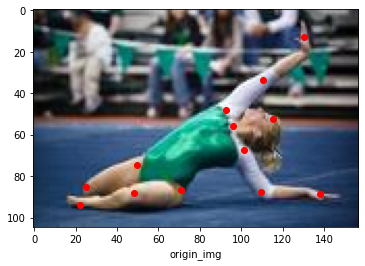

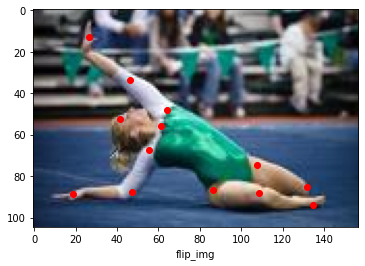

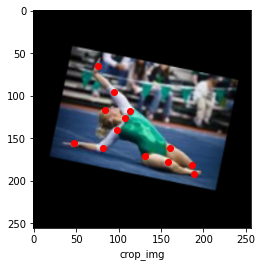

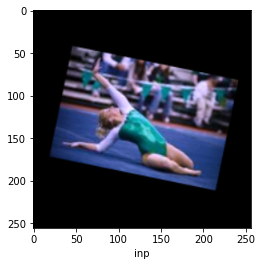

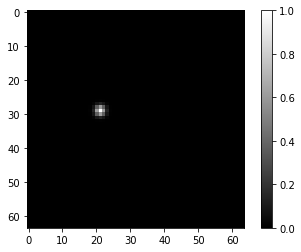

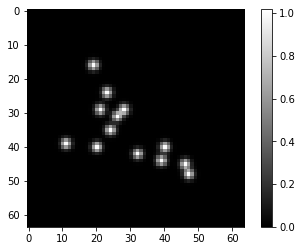

In [2]:
import matplotlib.pyplot as plt

# origin image and joint coordinates
plt.imshow(im_to_numpy(origin_img))
for p in range(nparts):
    if pts[p, 2] > 0:
        plt.scatter(pts[p, 0], pts[p, 1], c='r')
plt.xlabel('origin_img')
plt.show()

# flip
plt.imshow(im_to_numpy(flip_img))
for p in range(nparts):
    if flip_pts[p, 2] > 0:
        plt.scatter(flip_pts[p, 0], flip_pts[p, 1], c='r')
plt.xlabel('flip_img')
plt.show()

# scaling, rotating, cropping
plt.imshow(im_to_numpy(crop_img))
"""시각화를 위해 추가한 코드입니다."""
crop_pts = flip_pts.clone()
for p in range(nparts):
    if crop_pts[p, 2] > 0:
        crop_pts[p, 0:2] = to_torch(affine_transform(crop_pts[p, 0:2], c, s, [inp_res, inp_res], rot=r))
        plt.scatter(crop_pts[p, 0], crop_pts[p, 1], c='r')
plt.xlabel('crop_img')
plt.show()

# color jittering
plt.imshow(im_to_numpy(inp))
plt.xlabel('inp')
plt.show()

# ground-truth heatmap 시각화
plt.imshow(target[7], cmap='gray') # 머리(index:8)의 ground-truth heatmap을 출력합니다.
plt.colorbar()
plt.show() # 64x64 resolution

# 개별 heatmap을 한눈에 볼수있도록 element-wise하게 더해서 출력합니다.
gt_heatmap_all = torch.zeros(out_res, out_res)
for p in range(nparts):
    gt_heatmap_all += target[p]
plt.imshow(gt_heatmap_all, cmap='gray')
plt.colorbar()
plt.show()

실제 구현된 코드는 `lsp.py`에서 확인할 수 있습니다. <br/>
이후 LSP dataset 클래스는 3강에서 예시로 든 MNIST dataset을 다루던 것과 마찬가지로 동일하게 사용됩니다.

In [3]:
import os
import random
import json

import torch
import torchvision.transforms as tvtf
from torch.utils.data import Dataset

from codes.utils.osutils import *
from codes.utils.imutils import *
from codes.utils.transforms import *


def get_dataset(is_train=True, **kwargs):
    return LSP(is_train, **kwargs)


class LSP(Dataset):

    def __init__(self, is_train=True, **kwargs):
        self.img_folder = join_path('data', 'lsp')
        self.jsonfile = join_path('data', 'lsp', 'LEEDS_annotations.json')
        self.is_train = is_train
        self.inp_res = kwargs['inp_res']
        self.out_res = kwargs['out_res']
        self.sigma = kwargs['sigma'] # 1
        
        # create train/val split
        with open(self.jsonfile) as anno_file:
            self.anno = json.load(anno_file)
        
        self.train_list = []
        self.valid_list = []

        for idx, obj in enumerate(self.anno):
            # pelvis(mid-hip), thorax(mid-shoulder)는 불필요하므로 주석에서 제거하였습니다.
            pts = obj['joint_self']
            del pts[6:8] # keypoint 16 -> 14

            # train set과 validation set을 나눕니다.
            if obj['isValidation'] == True:
                self.valid_list.append(idx)
            else:
                self.train_list.append(idx)

        self.mean, self.std = self._compute_mean()

        if self.is_train:
            self.sf = 0.25 # scale factor
            self.rf = 30   # rotate factor
            self.transform = tvtf.Compose([ColorJittering(0.8, 1.2), 
                                            ColorNormalize(self.mean, self.std)])
        else:
            self.transform = tvtf.Compose([ColorNormalize(self.mean, self.std)])

    # Normalize에 사용할 train set의 평균과 표준편차를 계산합니다.
    def _compute_mean(self):
        meanstd_file = join_path('data', 'lsp', 'mean.pth.tar') 

        if isfile(meanstd_file):
            meanstd = torch.load(meanstd_file)
        else:
            mean = torch.zeros(3)
            std = torch.zeros(3)

            # Compute mean and standard deviation of all train set images
            for idx in self.train_list:
                obj = self.anno[idx]
                img_path = join_path(self.img_folder, get_correct_path(obj['img_paths']))
                img = load_image(img_path)
                mean += img.view(img.size(0), -1).float().mean(1)
                std += img.view(img.size(0), -1).float().std(1)
            mean /= len(self.train_list)
            std /= len(self.train_list)
            meanstd = {
                'mean': mean,
                'std': std
            }
            torch.save(meanstd, meanstd_file) # 파일로 저장
        
        if self.is_train:
            print('    Mean: %.4f, %.4f, %.4f' % (meanstd['mean'][0], meanstd['mean'][1], meanstd['mean'][2]))
            print('    Std:  %.4f, %.4f, %.4f' % (meanstd['std'][0], meanstd['std'][1], meanstd['std'][2]))

        return meanstd['mean'], meanstd['std']


    def __len__(self):
        if self.is_train:
            return len(self.train_list)
        else:
            return len(self.valid_list)


    def __getitem__(self, idx):
        if self.is_train:
            obj = self.anno[self.train_list[idx]]
        else:
            obj = self.anno[self.valid_list[idx]]

        img_path = join_path(self.img_folder, get_correct_path(obj['img_paths']))
        pts = torch.Tensor(obj['joint_self']) # keypoints 14 

        c = torch.Tensor(obj['objpos']) # rough human position in the image
        s = obj['scale_provided'] # person scale with respect to 200 px height

        # LSP uses matlab format, index is based 1,
        # we should first convert to 0-based index
        pts[:, 0:2] -= 1  
        c -= 1

        # Adjust center/scale slightly to avoid cropping limbs
        if c[0] != -1:
            #c[1] = c[1] + 15 * s
            s = s * 1.4375
        
        # For single-person pose estimation with a centered/scaled figure
        nparts = pts.size(0)
        img = load_image(img_path) # CxHxW

        # Transforms a image to feed the model's input
        r = 0
        if self.is_train:
            s = s * random.uniform(1 - self.sf, 1 + self.sf) # random scale
            r = random.uniform(-self.rf, self.rf) if random.random() <= 0.4 else 0 # random rotate

            # Flip
            if random.random() <= 0.5:
                img = fliplr_img(img)
                pts = fliplr_joints(pts, width=img.size(2), dataset='lsp')
                c[0] = img.size(2) - c[0]

        # scale, rotation, crop
        cropimg = crop(img, c, s, [self.inp_res, self.inp_res], rot=r)
        inp = self.transform(cropimg)

        # Generate ground truth
        tpts = pts.clone() # transformed points
        target = torch.zeros(nparts, self.out_res, self.out_res)
        target_weight = tpts[:, 2].clone().view(nparts, 1)

        for i in range(nparts):
            if tpts[i, 2] > 0:
                tpts[i, 0:2] = to_torch(affine_transform(tpts[i, 0:2], c, s, [self.out_res, self.out_res], rot=r))
                target[i], vis = draw_labelmap(target[i], tpts[i], self.sigma) # gaussian ground truth image
                target_weight[i, 0] *= vis

        # Meta info
        meta = {'index' : idx, 'center' : c, 'scale' : s, 
        'pts' : pts, 'tpts' : tpts, 'target_weight': target_weight}

        return cropimg, inp, target, meta
        